In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from hyperion.model import ModelOutput
import astropy.constants as const
from astropy.io import ascii, fits
pc = const.pc.cgs.value
c = const.c.cgs.value
dstar = 100
obs_dir = '/Volumes/SD-Mac/B335_obs_data/'

### Read in simulation

In [3]:
filename = '/Volumes/SD-Mac/model10.rtout'
m = ModelOutput(filename)

wl_aper, aper_arcsec = np.genfromtxt(obs_dir+'aperture.txt', skip_header=1, dtype=float).T

sed = m.get_sed(group=2, inclination=0,aperture=-1,distance=dstar*pc, uncertainties=True)

### Read in observation

In [7]:
phot = ascii.read(obs_dir+'b335.txt')
irs = ascii.read(obs_dir+'b335_spitzer_irs_full.txt')

/Users/yaolun/anaconda/envs/astroconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


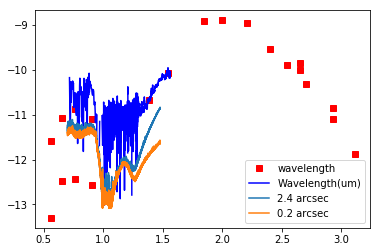

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

# observation
# photometry
ax.plot(np.log10(phot['wavelength']), np.log10(c/(phot['wavelength']*1e-4)*phot['flux']*1e-23), 'rs')
ax.plot(np.log10(irs['Wavelength(um)']), np.log10(c/(irs['Wavelength(um)']*1e-4)*irs['Flux(Jy)']*1e-23), 'b-')

# simulation
# ax.plot(np.log10(sed.wav), np.log10(sed.val), 'g-')
labels = ['2.4 arcsec', '0.2 arcsec']
for i in range(1,3):
    sed = m.get_sed(group=i, inclination=0,aperture=-1,distance=dstar*pc, uncertainties=True)
    ax.plot(np.log10(sed.wav), np.log10(sed.val), '-', label=labels[i-1])
ax.legend(loc='best')

### Output spectrum

In [11]:
sed = m.get_sed(group=2, inclination=0,aperture=-1,distance=dstar*pc, uncertainties=True)

foo = open('/Users/yaolun/research/PREMISE_ERS/B335_model/simulated_spectrum_200mas_hires.txt','w')
foo.write('{:<12s}\t{:<12s}\n'.format('Wave.(um)','Flux(Jy)'))
for i, (w, f) in enumerate(zip(sed.wav, sed.val)):
    foo.write('{:<12.6f}\t{:<12.8e}\n'.format(w,f/(c/w*1e4)*1e23))
foo.close()

### Plotting

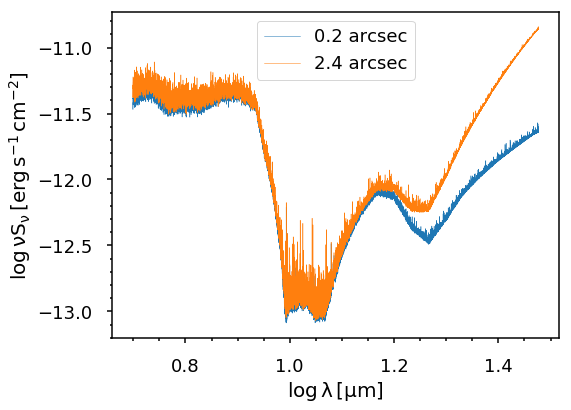

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sed200 = m.get_sed(group=2, inclination=0, aperture=-1, distance=dstar*pc,
                        uncertainties=True)

aper200, = ax.plot(np.log10(sed200.wav), np.log10(sed200.val), linewidth=0.5)

sed2400 = m.get_sed(group=1, inclination=0, aperture=-1, distance=dstar*pc,
                        uncertainties=True)

aper2400, = ax.plot(np.log10(sed2400.wav), np.log10(sed2400.val), linewidth=0.5)

ax.legend([aper200, aper2400], ['0.2 arcsec', '2.4 arcsec'], fontsize=18, loc='upper center')

ax.set_xlabel(r'$\rm{log\,\lambda\,[{\mu}m]}$',fontsize=20)
ax.set_ylabel(r'$\rm{log\,\nu S_{\nu}\,[erg\,s^{-1}\,cm^{-2}]}$',fontsize=20)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=15,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=15,length=2.5)

fig.savefig('/Users/yaolun/research/PREMISE_ERS/B335_MIRI.pdf', format='pdf', dpi=300, bbox_inches='tight')

/Users/yaolun/programs/misc/hyperion/get_obs.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sigma_dum[iwl] = np.std(np.hstack((flux_noise[i][0:sig_num/2],flux_noise[i][0:sig_num/2-iwl])))
/Users/yaolun/programs/misc/hyperion/get_obs.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sigma_dum[iwl] = np.std(flux_noise[i][iwl-sig_num/2:iwl+sig_num/2])
/Users/yaolun/programs/misc/hyperion/get_obs.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  sigma_dum[iwl] = np.std(np.hstack((flux_noise[i][iwl:],flux_noise[i][len(wl_noise[i])-sig_num/2:])))


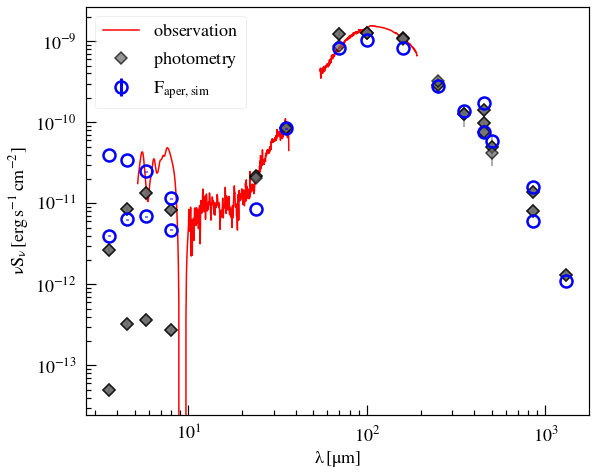

In [11]:
# modified from model_vs_obs in "sed_grid.py"
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from hyperion.model import ModelOutput
from hyperion.model import Model
from scipy.interpolate import interp1d
from hyperion.util.constants import pc, c, lsun
import sys
sys.path.append('/Users/yaolun/programs/misc/hyperion')
from get_obs import get_obs
from l_bol import l_bol

dstar = 100.0
modelname = '/model3/model3'
obs = '/Volumes/SD-Mac/B335_obs_data/'
# wl_aper = [3.6, 4.5, 5.8, 8.0, 24.0, 35.0, 70.0, 100.0, 160.0, 250.0, 350.0, 450.0, 500.0, 850.0, 1300.0]
rtout = False

# Read in the observation data and calculate the noise & variance
indir = '/Volumes/SD-Mac/'
outdir = '/Users/yaolun/test/'

source = get_obs(obs, obj='B335')  # in um and Jy
wave_obs, flux_obs, noise_obs = source['spec']
wave_phot, flux_phot, flux_sig_phot = source['phot']

# the full B335 Spitzer IRS spectrum
irs_data = ascii.read(obs+'b335_spitzer_irs_full.txt')
# need to rebin it
from astropy.convolution import convolve, Gaussian1DKernel
gauss = Gaussian1DKernel(stddev=3)
irs_data['Convolved_Flux(Jy)'] = convolve(irs_data['Flux(Jy)'], gauss)

# Convert the unit from Jy to erg cm-2 Hz-1
flux_obs = flux_obs*1e-23
noise_obs = noise_obs*1e-23
flux_phot = flux_phot*1e-23
flux_sig_phot = flux_sig_phot*1e-23

# Print the observed L_bol
wl_tot = np.hstack((wave_obs,wave_phot))
flux_tot = np.hstack((flux_obs,flux_phot))
flux_tot = flux_tot[np.argsort(wl_tot)]
wl_tot = wl_tot[np.argsort(wl_tot)]
l_bol_obs = l_bol(wl_tot,flux_tot*1e23, dstar)

# wl_aper = [3.6, 4.5, 5.8, 8.0, 8.5, 9, 9.7, 10, 10.5, 11, 16, 20, 24, 30, 70, 100, 160, 250, 350, 500, 850]

# Create the plot
mag = 1.5
fig = plt.figure(figsize=(6*mag,5*mag))
ax_sed = fig.add_subplot(111)

# # Plot the observed SED
# irs, = ax_sed.plot(np.log10(wave_obs[wave_obs<50]),
#                     np.log10(c/(wave_obs[wave_obs<50]*1e-4)*flux_obs[wave_obs<50]),
#                     '-', color='r', alpha=1, linewidth=1.5, zorder=10)
# pacs, = ax_sed.plot(np.log10(wave_obs[(wave_obs>50)&(wave_obs<190.31)]),
#                      np.log10(c/(wave_obs[(wave_obs>50)&(wave_obs<190.31)]*1e-4)*flux_obs[(wave_obs>50)&(wave_obs<190.31)]),
#                      '-', color='r', alpha=1, linewidth=1.5, zorder=10)
# spire, = ax_sed.plot(np.log10(wave_obs[wave_obs>194]),
#                    np.log10(c/(wave_obs[wave_obs>194]*1e-4)*flux_obs[wave_obs>194]),
#                    '-', color='r', alpha=1, linewidth=1.5, zorder=10)

# # plot the observed photometry data
# photometry, = ax_sed.plot(np.log10(wave_phot),
#                           np.log10(c/(wave_phot*1e-4)*flux_phot),
#                           'D', mfc='DimGray', mec='k',markersize=8, markeredgewidth=1.5, zorder=20, alpha=0.7)
# ax_sed.errorbar(np.log10(wave_phot),np.log10(c/(wave_phot*1e-4)*flux_phot),
#     yerr=[np.log10(c/(wave_phot*1e-4)*flux_phot)-np.log10(c/(wave_phot*1e-4)*(flux_phot-flux_sig_phot)),
#           np.log10(c/(wave_phot*1e-4)*(flux_phot+flux_sig_phot))-np.log10(c/(wave_phot*1e-4)*flux_phot)],
#     fmt='D',mfc='DimGray',mec='k',markersize=8, ecolor='DimGray',
#     elinewidth=1.5, barsabove=True, linewidth=1.5, markeredgewidth=1.5, zorder=20, alpha=0.7)

# Plot the observed SED
irs, = ax_sed.plot(wave_obs[wave_obs<50],
                    c/(wave_obs[wave_obs<50]*1e-4)*flux_obs[wave_obs<50],
                    '-', color='r', alpha=1, linewidth=1.5, zorder=10)
pacs, = ax_sed.plot(wave_obs[(wave_obs>50)&(wave_obs<190.31)],
                     c/(wave_obs[(wave_obs>50)&(wave_obs<190.31)]*1e-4)*flux_obs[(wave_obs>50)&(wave_obs<190.31)],
                     '-', color='r', alpha=1, linewidth=1.5, zorder=10)
spire, = ax_sed.plot(irs_data['Wavelength(um)'],
                   c/(irs_data['Wavelength(um)']*1e-4)*irs_data['Convolved_Flux(Jy)']*1e-23,
                   '-', color='r', alpha=1, linewidth=1.5, zorder=10)

# plot the observed photometry data
photometry, = ax_sed.plot(wave_phot,
                          c/(wave_phot*1e-4)*flux_phot,
                          'D', mfc='DimGray', mec='k',markersize=8, markeredgewidth=1.5, zorder=20, alpha=0.7)
ax_sed.errorbar(wave_phot,c/(wave_phot*1e-4)*flux_phot,
    yerr=(c/(wave_phot*1e-4)*(flux_sig_phot)),
    fmt='D',mfc='DimGray',mec='k',markersize=8, ecolor='DimGray',
    elinewidth=1.5, barsabove=True, linewidth=1.5, markeredgewidth=1.5, zorder=20, alpha=0.7)

# read in the raw output from hyperion and then save the extraction results in text file, otherwise read the text files instead.

# Open the model
if rtout:
    m = ModelOutput(indir+modelname+'.rtout')

    sed_inf = m.get_sed(group=0, inclination=0, aperture=-1, distance=dstar * pc)
    flux_aper = np.empty_like(wl_aper)
    unc_aper = np.empty_like(wl_aper)
    for i in range(0, len(wl_aper)):
        print(wl_aper[i])
        sed_dum = m.get_sed(group=i+1, inclination=0, aperture=-1, distance=dstar * pc)
        # use a rectangle function the average the simulated SED
        # apply the spectral resolution
        if (wl_aper[i] < 50.) & (wl_aper[i] >= 5):
            res = 60.
        elif wl_aper[i] < 5:
            res = 10.
        else:
            res = 1000.
        ind = np.where((sed_dum.wav < wl_aper[i]*(1+1./res)) & (sed_dum.wav > wl_aper[i]*(1-1./res)))
        if len(ind[0]) != 0:
            flux_aper[i] = np.mean(sed_dum.val[ind])
        else:
            f = interp1d(sed_dum.wav, sed_dum.val)
            flux_aper[i] = f(wl_aper[i])

    # make the variables consistent with others
    sim_inf = sed_inf.wav
    sim_sed_inf = sed_inf.val

    # save the results in text files
    # unapertured SED
    foo = open(outdir+modelname+'_sed_inf.txt','w')
    foo.write('%12s \t %12s \n' % ('wave','vSv'))
    for i in range(0, len(sed_inf.wav)):
        foo.write('%12g \t %12g \n' % (sed_inf.wav[i], sed_inf.val[i]))
    foo.close()
    # SED with convolution of aperture sizes
    foo = open(outdir+modelname+'_sed_w_aperture.txt','w')
    foo.write('%12s \t %12s \n' % ('wave','vSv'))
    for i in range(0, len(wl_aper)):
        foo.write('%12g \t %12g \n' % (wl_aper[i], flux_aper[i]))
    foo.close()
else:
    (sim_inf, sim_sed_inf, sim_sed_inf_unc) = np.genfromtxt(indir+modelname+'_sed_inf.txt', skip_header=1).T
    (wl_aper, flux_aper, unc_aper) = np.genfromtxt(indir+modelname+'_sed_w_aperture.txt', skip_header=1).T

# perform the same procedure of flux extraction of aperture flux with observed spectra
wl_aper = np.array(wl_aper)
obs_aper_wl = wl_aper[(wl_aper >= min(wave_obs)) & (wl_aper <= max(wave_obs))]
obs_aper_sed = np.empty_like(obs_aper_wl)
sed_tot = c/(wl_tot*1e-4)*flux_tot
# wl_tot and flux_tot are already hstacked and sorted by wavelength
for i in range(0, len(obs_aper_wl)):
    if (obs_aper_wl[i] < 50.) & (obs_aper_wl[i] >= 5):
        res = 60.
    elif obs_aper_wl[i] < 5:
        res = 10.
    else:
        res = 1000.
    ind = np.where((wl_tot < obs_aper_wl[i]*(1+1./res)) & (wl_tot > obs_aper_wl[i]*(1-1./res)))
    if len(ind[0]) != 0:
        obs_aper_sed[i] = np.mean(sed_tot[ind])
    else:
        f = interp1d(wl_tot, sed_tot)
        obs_aper_sed[i] = f(wl_aper[i])
    
# aper_obs, = ax_sed.plot(np.log10(obs_aper_wl),np.log10(obs_aper_sed),
#                         'D', mec='k', mfc='DimGray', color='DimGray', markersize=8, linewidth=1.5,
#                         markeredgewidth=1.5, zorder=20, alpha=0.7)

# aper = ax_sed.errorbar(np.log10(wl_aper),np.log10(flux_aper),
#                        yerr=[np.log10(flux_aper)-np.log10(flux_aper-unc_aper),
#                              np.log10(flux_aper+unc_aper)-np.log10(flux_aper)],
#                        fmt='o', linestyle='None', mec='Blue', mfc='None', color='b',
#                        markersize=12, markeredgewidth=2.5, linewidth=1.7, ecolor='Blue',
#                        elinewidth=3, barsabove=True, zorder=30)

aper_obs, = ax_sed.plot(obs_aper_wl,obs_aper_sed,
                        'D', mec='k', mfc='DimGray', color='DimGray', markersize=8, linewidth=1.5,
                        markeredgewidth=1.5, zorder=20, alpha=0.7)

aper = ax_sed.errorbar(wl_aper,flux_aper,
                       yerr=unc_aper,
                       fmt='o', linestyle='None', mec='Blue', mfc='None', color='b',
                       markersize=12, markeredgewidth=2.5, linewidth=1.7, ecolor='Blue',
                       elinewidth=3, barsabove=True, zorder=30)

# # calculate the bolometric luminosity of the aperture
# l_bol_sim = l_bol(wl_aper, flux_aper/(c/np.array(wl_aper)*1e4)*1e23, dstar)
# print 'Bolometric luminosity of simulated spectrum: %5.2f lsun' % l_bol_sim

# plot setting
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
ax_sed.set_xlabel(r'$\rm{\lambda\,[{\mu}m]}$',fontsize=18)
ax_sed.set_ylabel(r'$\rm{\nu S_{\nu}\,[erg\,s^{-1}\,cm^{-2}]}$',fontsize=18)
[ax_sed.spines[axis].set_linewidth(1.2) for axis in ['top','bottom','left','right']]
ax_sed.minorticks_on()
ax_sed.tick_params('both',labelsize=18,width=1.2,which='major',pad=10,length=10)
ax_sed.tick_params('both',labelsize=18,width=1.2,which='minor',pad=10,length=5)

# ax_sed.set_ylim([-13,-8.5])
# ax_sed.set_xlim([0.2,3.3])
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
ax_sed.set_xscale('log')
ax_sed.set_yscale('log')

lg_data = ax_sed.legend([irs, photometry, aper],\
    [r'$\rm{observation}$',\
    r'$\rm{photometry}$',r'$\rm{F_{aper,sim}}$'],\
    loc='upper left',fontsize=18,numpoints=1,framealpha=0.3)

# Write out the plot
fig.savefig(outdir+'B335_sed.pdf',format='pdf',dpi=300,bbox_inches='tight')
# fig.clf()

### Stitch the image slices - for a complete image cube

In [4]:
# MIRI 15 um filter
m = ModelOutput('/Volumes/SD-Mac/model22.rtout')
im = m.get_image(group=0, inclination=0, distance=dstar*pc, units='MJy/sr')
rmax = max(m.get_quantities().r_wall)
w = np.degrees(rmax / im.distance) * 3600.
print(2*w/len(im.val[:,0,0]))

0.0995930007113


In [6]:
print(w, rmax/1.5e13)

99.5930007113 9932.60056194


In [27]:
np.shape(im.val)

(2000, 2000, 20)

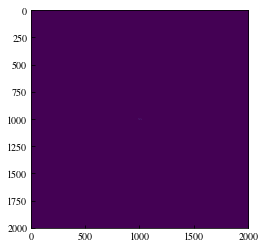

In [28]:
plt.imshow(im.val[:,:,10])

In [30]:
# output only 5-30 um, for MIRI
fits.writeto('/Users/yaolun/research/PREMISE_ERS/B335_model/B335_simulation_MIRI_25um.fits',
             im.val.swapaxes(0, 2).swapaxes(1, 2), overwrite=True)

# output wavelength solution
foo = open('/Users/yaolun/research/PREMISE_ERS/B335_model/B335_simulation_MIRI_wavesol_25um.txt', 'w')
foo.write('{:<6s}\t{:<12s}\n'.format('Index', 'Wave.(um)'))
for i, w in enumerate(im.wav):
    foo.write('{:<6d}\t{:<12.6f}\n'.format(i,w))
foo.close()

### Stitch the image slices - for multiple monochromatic runs

In [24]:
wave = ['15','25']
rtouts = ['/Volumes/SD-Mac/model15.rtout', '/Volumes/SD-Mac/model16.rtout']

val = []
for rtout in rtouts:
    m = ModelOutput(rtout)
    im = m.get_image(group=0, inclination=0, distance=dstar*pc, units='MJy/sr')
    val.append(im.val)

all_im = np.concatenate(val, axis=2)

# output only 15 um and 25 um, for MIRI
fits.writeto('/Volumes/SD-Mac/B335_simulation_MIRI_hires.fits',
             all_im.swapaxes(0, 2).swapaxes(1, 2), overwrite=True)